In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import PHILIPS2LBOTTLE, PHILIPS1L5BOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency

def show_test_result(passed):
    if passed:
        return HTMLLatex(
            '<b>Test Result - <span style="color:green">ACCEPTABLE</span></b>',
             r'\textbf{Test Result -- \color{green}ACCEPTABLE}'
        )
    else:
        return HTMLLatex(
            '<b>Test Result - <span style="color:red">FAILED</span></b>',
             r'\textbf{Test Result -- \color{red}FAILED}'
        )

# Watermark
wm = watermark()
display(pd.DataFrame(
    {'Watermark': list(wm.values())},
    index=wm.keys()
))

Watermark
CalculationTime  2022-04-11T17:32:54+01:00
User                        birchhub/rtrhd
PythonVersion                CPython 3.9.9
Platform          Linux 4.15.0-159-generic
mriqa                               0.2.11
dcmextras                            0.2.6
pydicom                              2.2.2
scipy                                1.7.3
numpy                               1.22.0
skimage                             0.19.1
matplotlib                           3.5.1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil Image Uniformity
- Head Coil SNR

----

All of the above are acceptable.

----

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid
series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(
    tests['SliceProfile_PIQT']['PatID'], 
    tests['SliceProfile_PIQT']['StudyID'], 
    sernos=tests['SliceProfile_PIQT']['Series']['3mm'], 
    imagesonly=True
)[0]

scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')

display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner     PHILIPS-3FDMLA4
Date               20190125
Patient  AQA20190104NBTMR21
Study             599585524

In [3]:
text = f'''
{operator}
Medical Physics & Bioengineering, UH Bristol
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))

In [4]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo using the PIQT slice profile block.

### 3 mm Slice

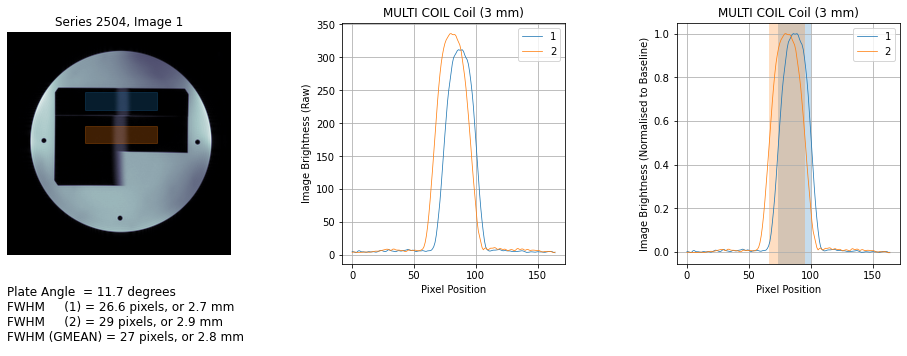

In [5]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series, imagesonly=True)
if len(dobjs) > 1: #accommodate multiframes
    results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
else:
    results = slice_profile_report(dobjs[0], frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

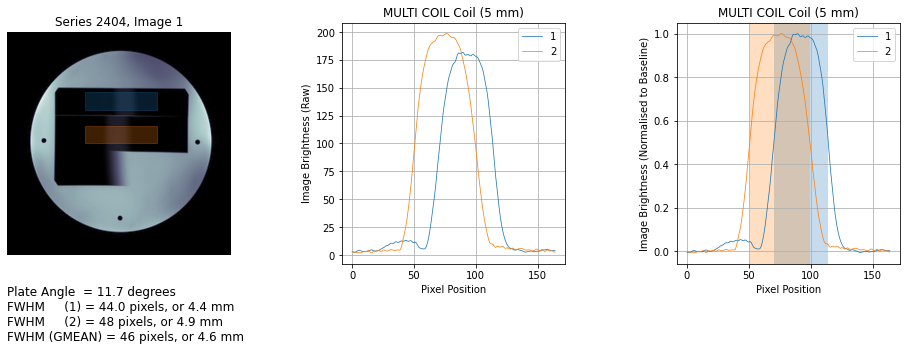

In [6]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series, imagesonly=True)
if len(dobjs) > 1: #accommodate multiframes
    result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
else:
    result = slice_profile_report(dobjs[0], frame=slice_idx, phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [7]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                27.8             2.8
5.0                                46.3             4.6

These profile widths are well within the AAPM tolerance of 0.5mm. The variation between profiles 1 and 2 for both slice widths, and the clipping of the profiles of the more central channel, are an artefact of minor mispositioning of the phantom.

In [8]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a a grid of objects for scale and distortion measurements in plane. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. These results are before and after applying Philips 2D distortion correction.

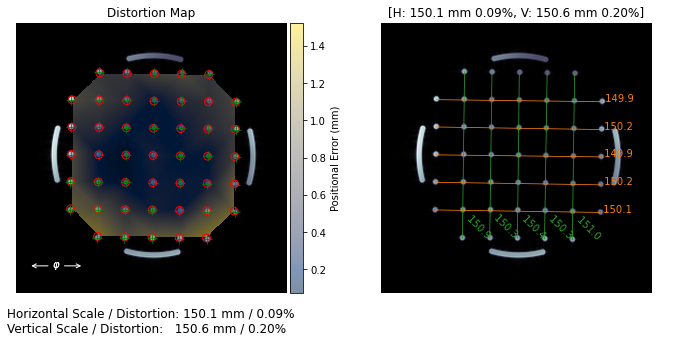

In [9]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, studyid, sernos=series['AxialRL_Uncorrected'], imagesonly=True)
if len(dobjs) > 1: #accommodate multiframes
    results = piqt_distortion_report(dobjs[slices['AxialRL_Uncorrected']])
else:
    results = piqt_distortion_report(dobjs[0], frame=slices['AxialRL_Uncorrected'])

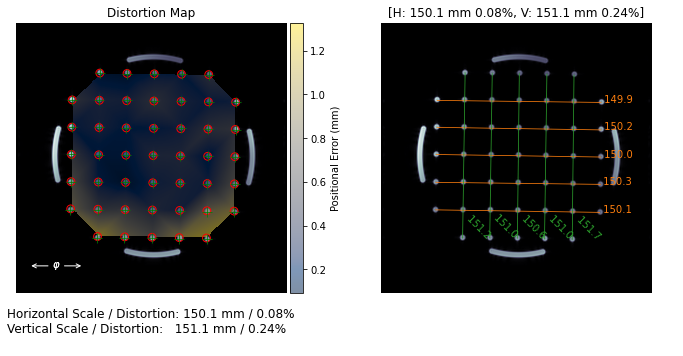

In [10]:
# PIQT: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'], imagesonly=True)
if len(dobjs) > 1: #accommodate multiframes
    results.append(piqt_distortion_report(dobjs[slices['AxialRL_Corrected']]))
else:
    results = results.append(piqt_distortion_report(dobjs[0], frame=slices['AxialRL_Corrected']))

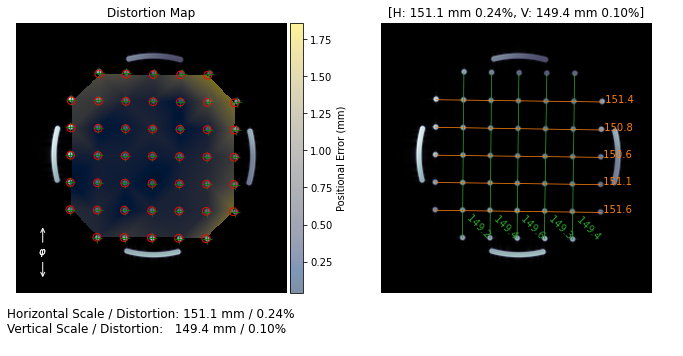

In [11]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, studyid, sernos=series['AxialAP_Uncorrected'], imagesonly=True)
if len(dobjs) > 1: #accommodate multiframes
    results.append(piqt_distortion_report(dobjs[slices['AxialAP_Uncorrected']]))
else:
    results = results.append(piqt_distortion_report(dobjs[0], frame=slices['AxialAP_Uncorrected']))

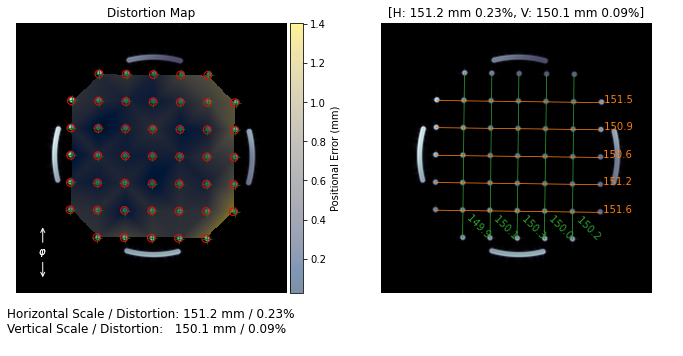

In [12]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, studyid, sernos=series['AxialAP_Corrected'], imagesonly=True)
if len(dobjs) > 1: #accommodate multiframes
    results.append(piqt_distortion_report(dobjs[slices['AxialAP_Corrected']]))
else:
    results = results.append(piqt_distortion_report(dobjs[0], frame=slices['AxialAP_Corrected']))

In [13]:
pd.set_option('precision', 3)
results[[
    'Orientation', 'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion'  
})

Orientation Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                                   
2504         Axial              RL        0.476                150.052   
2503         Axial              RL        0.476                150.088   
2604         Axial              AP        0.476                151.117   
2603         Axial              AP        0.476                151.160   

        Horizontal Distortion  Vertical Scale (mm)  Vertical Distortion  
Series                                                                   
2504                    0.086              150.578                0.203  
2503                    0.082              151.102                0.239  
2604                    0.242              149.396                0.101  
2603                    0.231              150.100                0.089

The scale in both the RL and AP directions are well within 1% at the bandwidth used (260Hz/pixel). Whilst not at a level of concern, image scaling and distortion appear to be slightly worse in the FE direction, which could result from $B_0$ or $B_1$ uniformity problems, gradient instability, or ADC errors. It appears unaffected by Philips 2D distortion correction (series 2504, 2604 are uncorrected, series 2503, 2603 are corrected). If this trend continues it may be worth investigating in more detail.

In [14]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom.

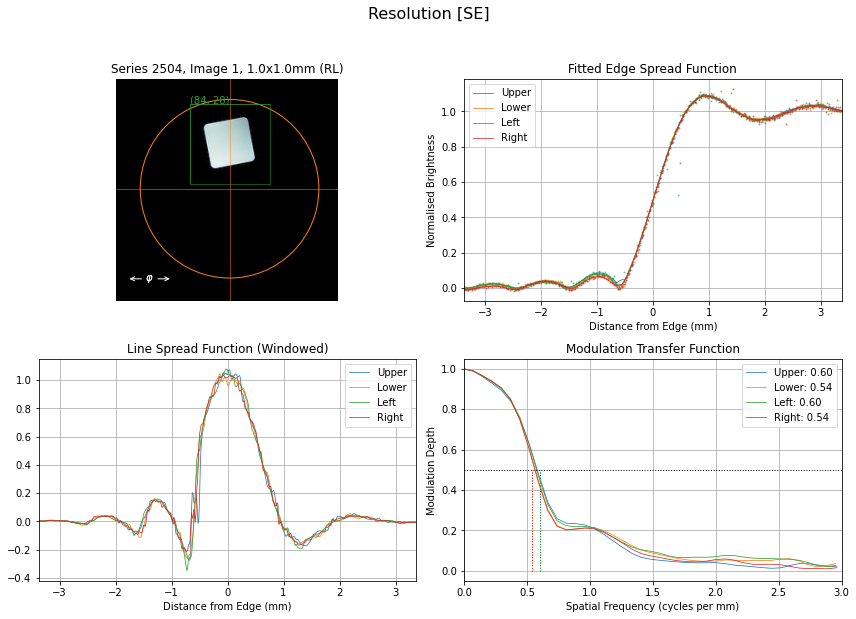

MTF_50
Upper   0.605
Lower   0.542
Left    0.603
Right   0.544

In [15]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
#no 512 acquisition, using 256
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']], imagesonly=True), key=lambda d: int(d.InstanceNumber))
if len(dobjs) > 1: #accommodate multiframes
    dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]
    results = mtf_report(dobj_mtf, dobj_centre)
else:
    results = mtf_report(dobjs[0], mtf_frame=slices['MTF'], centring_frame=slices['Centre'])
plt.show()
results

# used 3mm uncorrected PIQT volume, is this correct in the absence of a 512?

The MTF_50 is consistent with an image resolution of 1 x 1 mm. The aberrant behaviour of the lower edge fit is due to instability in fitting and is not a cause for concern.

In [16]:
NewPage

## Ghosting

Image ghosting is assessed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and four example sequences.

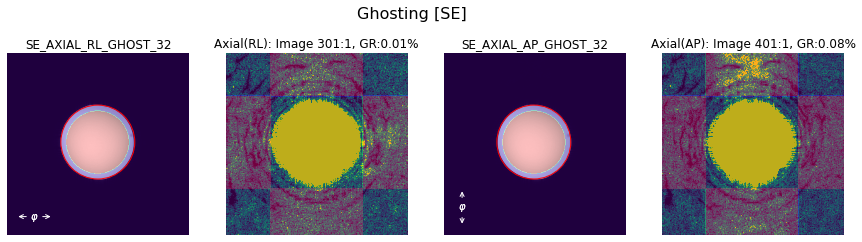

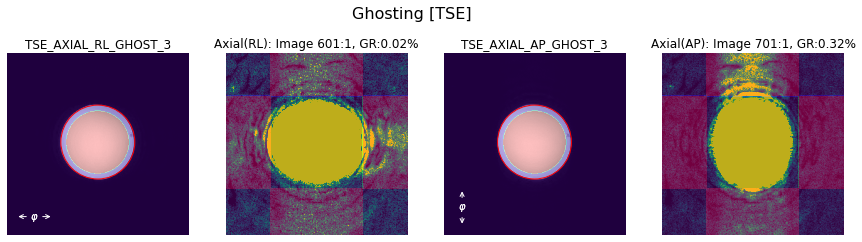

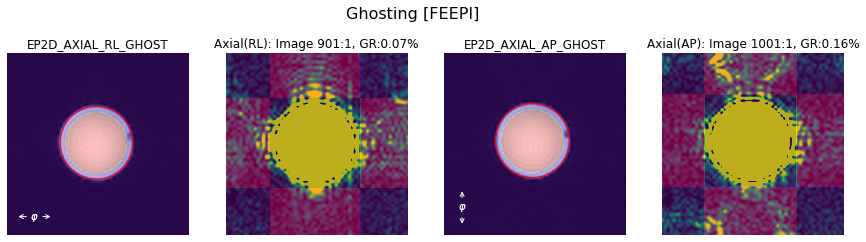

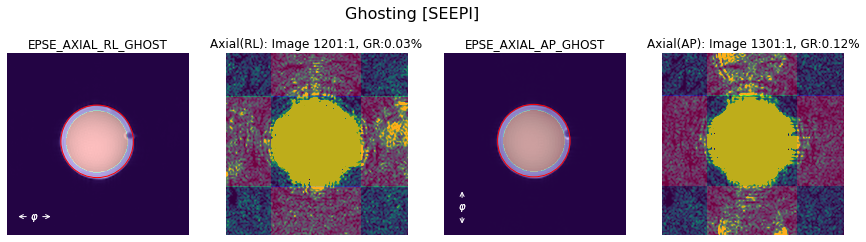

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                      
301          SE       Axial              RL            0.011
401          SE       Axial              AP            0.077
601         TSE       Axial              RL            0.021
701         TSE       Axial              AP            0.317
901       FEEPI       Axial              RL            0.071
1001      FEEPI       Axial              AP            0.157
1201      SEEPI       Axial              RL            0.033
1301      SEEPI       Axial              AP            0.123

In [17]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno], imagesonly=True)[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is under 1% for all sequences measured here including the EPIs. The worst ghosting is seen on the TSE and is due to unusually bright stimulated echo ghosts interacting with uniformity filters which could not be disabled.

In [18]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the head coil using a spherical phantom filled with silicone oil. Results are presented both before and after `CLEAR` intensity correction.

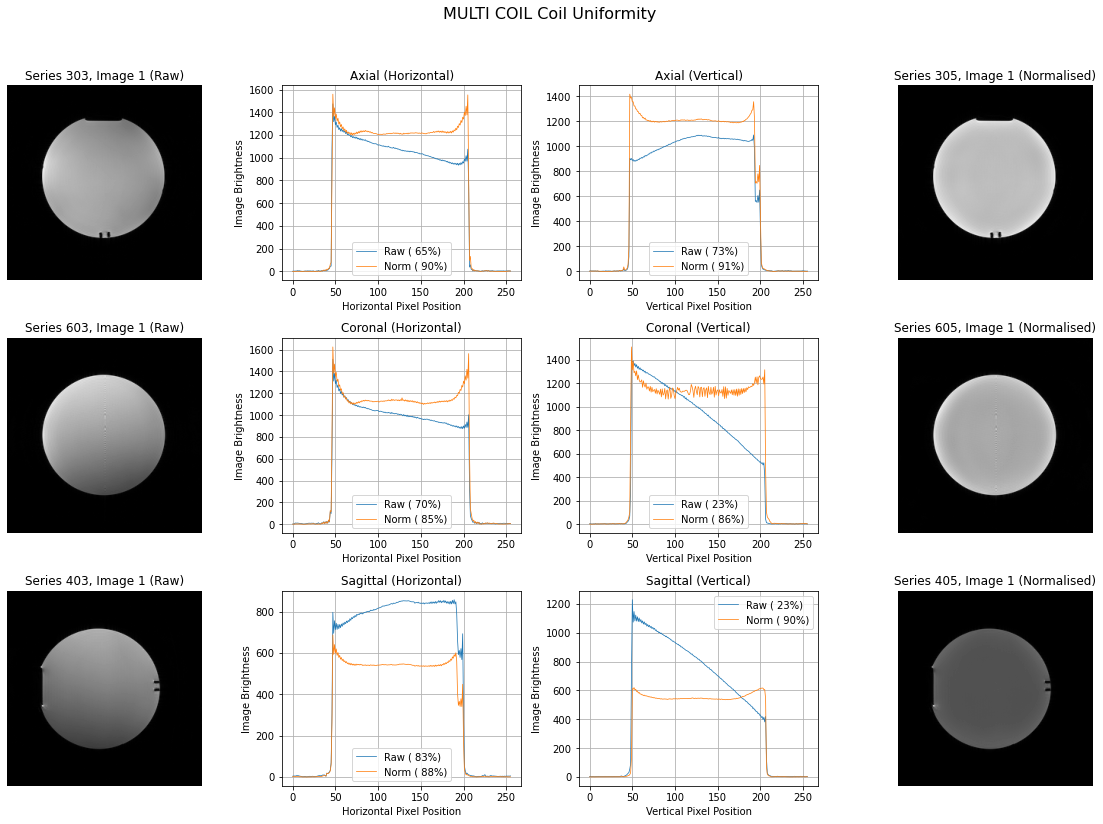

Raw Images


Series No.                              Protocol         Axis  \
Orientation                                                                  
Axial               303  SE_AXIAL_RL_UNIF_OILSPHERE_32CH_NONE     Axial/RL   
Coronal             603    SE_COR_RL_UNIF_OILSPHERE_32CH_NONE   Coronal/RL   
Sagittal            403    SE_SAG_AP_UNIF_OILSPHERE_32CH_NONE  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    64.60             72.73  
Coronal                  69.75             23.42  
Sagittal                 82.58             22.78

Intensity Normalised Images


Series No.                               Protocol         Axis  \
Orientation                                                                   
Axial               305  SE_AXIAL_RL_UNIF_OILSPHERE_32CH_CLEAR     Axial/RL   
Coronal             605    SE_COR_RL_UNIF_OILSPHERE_32CH_CLEAR   Coronal/RL   
Sagittal            405    SE_SAG_AP_UNIF_OILSPHERE_32CH_CLEAR  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    90.06             90.91  
Coronal                  85.19             85.53  
Sagittal                 88.39             89.81

In [19]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0], imagesonly=True)
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1], imagesonly=True)
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0], imagesonly=True)
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1], imagesonly=True)
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0], imagesonly=True)
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1], imagesonly=True)

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. However, the Philips `CLEAR` intensity correction is adequate in compensating for this.

In [20]:
NewPage

## Signal to Noise

For reference purposes the following is an independent estimate for the head coil using the Philips 2L bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### High Density Head Coil

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

MULTI COIL
0.50      254.64
0.75      268.33

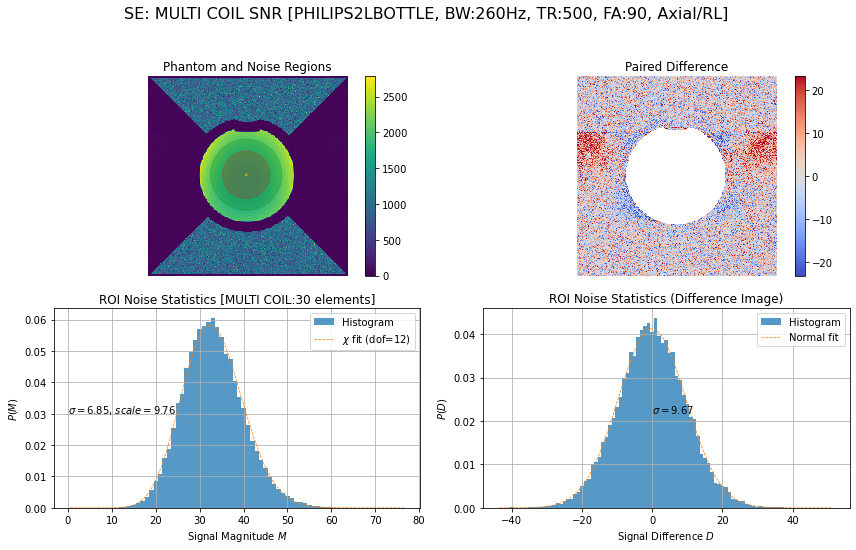

In [21]:
# SNR (uncombined channels)
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

from mriqa.dcmio import coil_elements
dobjs = fetch_series(patid, stuid, series['Signal'], imagesonly=True)

if len(dobjs) > 2: #accommodate multiframes
    dobjs = sorted(dobjs, key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0]))
    nchannels = len(set(coil_elements(d)[0] for d in dobjs))
    dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]
elif len(dobjs) > 1:
    dobjs = sorted(dobjs, key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber)))
    dobjsa, dobjsb = dobjs[0], dobjs[1]
else:
    dobjs = sorted(dobjs, key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber)))

with pd.option_context('display.precision', 2):
    if len(dobjs) > 1:
        display(snr_report_multi(dobjsa, dobjsb, phantom=PHILIPS2LBOTTLE))
    else:
        display(snr_report_multi(dobjs, phantom=PHILIPS2LBOTTLE))

The noise distribution and SNR values are acceptable. The noise field is notably stable compared to previous instances.

In [22]:
NewPage

## Long Term Stability
The long term stability of an EPI acquisition over a period of 20 minutes. This was performed on a spherical gel phantom using the baseline EPI sequence with a reduced number of slices as BOLD-EPI was not available.

In [23]:
# FBIRN Spherical Phantom: Long Term stability
#info = tests['Stability']
#patid, studyid = info['PatID'], info['StudyID']
#series = info['Series']

#dobjs = fetch_series(patid, studyid, sernos=series['Long_20min'], imagesonly=True)
#results = fbirn_full_report(dobjs)
#plt.show()
#results

# series is a one-frame...something. Need to track down the *real* fbirn series.

No scans were available for this test at the time.

## Frequency Reference
These is the reference value reported in the DICOM header of a SE scan.

In [24]:
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series, imagesonly=True)[0]
pd.DataFrame({
    'ImagingFrequency': [larmor_frequency(dobj)]
}, index=['Value']).T

Value
ImagingFrequency  127.758